# Lab4: Advanced Neural Nets



In [3]:
import os
import re
import cv2
import csv
import nltk
import glob
import feedparser

from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import keras.utils as ku
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid

import sentencepiece
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration

from tqdm.notebook import tqdm

from PIL import Image
from IPython.display import Image as img

In [2]:
!pip install feedparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=89d73b823b75721f6e49c3c4d5fd1e1e2daaf3a8fe81803c86d8906ce8024c46
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [4]:
!pip install sentencepiece


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


Хід роботи:
## 1. Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір)

Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

Використаний датасет: https://tsn.ua/rss/full.rss

In [7]:
def rss_to_csv(feed_url, csv_filename):
    feed = feedparser.parse(feed_url)

    if feed.bozo == 0:
        data = []

        for entry in feed.entries:
            title = entry.title
            fulltext = entry.fulltext

            data.append([title, fulltext])

        df = pd.DataFrame(data, columns=['Title', 'fulltext'])
        df.to_csv(csv_filename, index=False, encoding='utf-8')

        print(f"Data scraped from '{feed_url}' and written to '{csv_filename}'")
    else:
        print(f"Error parsing the feed: {feed.bozo_exception}")

rss_feed_url = 'https://tsn.ua/rss/full.rss'
csv_output_filename = 'scraped.csv'
rss_to_csv(rss_feed_url, csv_output_filename)

Data scraped from 'https://tsn.ua/rss/full.rss' and written to 'scraped.csv'


In [26]:
df = pd.read_csv('scraped.csv')

In [9]:
df

Title  \
0         Федоров пожартував з приводу повісток в "Дії"   
1           На Сумщині пролунало 26 вибухів: що сталося   
2     Рибам варто розслабитися, а Скорпіонам потрібн...   
3     Байден підписав рекордний бюджет Пентагону з м...   
4           ТСН за 22 грудня 2023 року | Новини України   
...                                                 ...   
1485  Шоста повітряна атака на Київ від початку міся...   
1486  Як потрібно змінити правила мобілізації: думка...   
1487  У Курській області РФ - три прильоти та пошкод...   
1488  Вперше під час війни Ізраїль дозволив перехід ...   
1489  Таропрогноз на грудень 2023 року: що карти нам...   

                                               fulltext  
0     <p>Міністр цифрової трансформації Михайло Федо...  
1     <p><strong>Стала відома ситуація на прикордонн...  
2     <p>Гороскоп для всіх знаків зодіаку за <strong...  
3     <p>Президент США Джо Байден зробив заяву щодо ...  
4                                        <p>       </p>  
...                                                 ...  
1485  <p><strong>Судячи із застосованого озброєння, ...  
1486  <p>Командир 1-го штурмового батальйону 3-ї окр...  
1487  <p><strong>Російська влада заявила про атаку н...  
1488  <p>Уперше під час війни кабінет міністрів схва...  
1489  <p> <strong>Таро — це карткова колода з чітко ...  

[1490 rows x 2 columns]

In [27]:
# https://github.com/skupriienko/Ukrainian-Stopwords
with open("drive/MyDrive/IPT masters/9 sem/Інтелектуальний аналіз даних/lab4/stopwords_ua.txt") as f:
    stopwords = set(f.read().splitlines())

In [28]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r"[^\w\s]|(\w+:\/\/\S+)|^rt|http.+?|(@\[A-Za-z0-9]+)", "", text)
  text = re.sub(r"\s+", " ", text)
  text = ' '.join([word for word in text.split(' ') if word not in stopwords])
  return text

df['Title'] = df['Title'].apply(clean_text)

In [29]:
df

Title  \
0               федоров пожартував приводу повісток дії   
1                  сумщині пролунало 26 вибухів сталося   
2     рибам варто розслабитися скорпіонам сміливо ру...   
3     байден підписав рекордний бюджет пентагону міл...   
4                     тсн 22 грудня 2023 новини україни   
...                                                 ...   
1485  шоста повітряна атака київ місяця ворожі цілі ...   
1486  змінити правила мобілізації думка командира шт...   
1487  курській області рф прильоти пошкоджена леп вл...   
1488  вперше війни ізраїль дозволив перехід сектор г...   
1489             таропрогноз грудень 2023 карти віщують   

                                               fulltext  
0     <p>Міністр цифрової трансформації Михайло Федо...  
1     <p><strong>Стала відома ситуація на прикордонн...  
2     <p>Гороскоп для всіх знаків зодіаку за <strong...  
3     <p>Президент США Джо Байден зробив заяву щодо ...  
4                                        <p>       </p>  
...                                                 ...  
1485  <p><strong>Судячи із застосованого озброєння, ...  
1486  <p>Командир 1-го штурмового батальйону 3-ї окр...  
1487  <p><strong>Російська влада заявила про атаку н...  
1488  <p>Уперше під час війни кабінет міністрів схва...  
1489  <p> <strong>Таро — це карткова колода з чітко ...  

[1490 rows x 2 columns]

In [32]:
tokenizer = Tokenizer(char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Title'])

total_chars = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(df['Title'])

input_sequences = []
for sequence in sequences:
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = np.array(tf.keras.utils.to_categorical(y, num_classes=total_chars))

In [33]:
model = Sequential()
model.add(Embedding(total_chars, 50, input_length=max_sequence_length-1))
model.add(LSTM(100))
model.add(Dense(total_chars, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model.fit(X, y, epochs=100, verbose=2)

Epoch 1/100
331/331 - 12s - loss: 8.5529 - accuracy: 0.0084 - 12s/epoch - 37ms/step
Epoch 2/100
331/331 - 10s - loss: 8.0691 - accuracy: 0.0126 - 10s/epoch - 30ms/step
Epoch 3/100
331/331 - 11s - loss: 7.8164 - accuracy: 0.0153 - 11s/epoch - 33ms/step
Epoch 4/100
331/331 - 9s - loss: 7.5384 - accuracy: 0.0195 - 9s/epoch - 28ms/step
Epoch 5/100
331/331 - 10s - loss: 7.2183 - accuracy: 0.0263 - 10s/epoch - 32ms/step
Epoch 6/100
331/331 - 12s - loss: 6.8828 - accuracy: 0.0324 - 12s/epoch - 37ms/step
Epoch 7/100
331/331 - 9s - loss: 6.5279 - accuracy: 0.0398 - 9s/epoch - 28ms/step
Epoch 8/100
331/331 - 10s - loss: 6.1788 - accuracy: 0.0486 - 10s/epoch - 31ms/step
Epoch 9/100
331/331 - 11s - loss: 5.8440 - accuracy: 0.0630 - 11s/epoch - 33ms/step
Epoch 10/100
331/331 - 10s - loss: 5.5206 - accuracy: 0.0815 - 10s/epoch - 29ms/step
Epoch 11/100
331/331 - 11s - loss: 5.2186 - accuracy: 0.1015 - 11s/epoch - 32ms/step
Epoch 12/100
331/331 - 11s - loss: 4.9235 - accuracy: 0.1393 - 11s/epoch - 33m

In [38]:
seed_text = "війна"
next_words = 10

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted_probs = model.predict(token_list, verbose=0)[0]
    predicted_index = np.argmax(predicted_probs)
    output_word = ""

    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    seed_text += " " + output_word

print(seed_text)

війна вплинула підготовку вступу внз кордоном росіянина воює столиці києві дня


## 2. HF Transformers

Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

Аналіз настрою тексту:

In [ ]:
task = "sentiment-analysis"
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

classifier = pipeline(task, model=model_name)

In [52]:
text_to_analyze = "чел"
result = classifier(text_to_analyze)

print(result)

[{'label': '3 stars', 'score': 0.2709943354129791}]


In [54]:
text_to_analyze = "чел)"
result = classifier(text_to_analyze)

print(result)

[{'label': '3 stars', 'score': 0.26933684945106506}]


In [55]:
text_to_analyze = "чел)))))"
result = classifier(text_to_analyze)

print(result)

[{'label': '4 stars', 'score': 0.2760932147502899}]


In [6]:
model_name = "t5-base"
model_revision = "686f1db"
model_max_length = 1024

tokenizer = T5Tokenizer.from_pretrained(model_name, revision=model_revision, model_max_length=model_max_length)

model = T5ForConditionalGeneration.from_pretrained(model_name, revision=model_revision)
translator = pipeline(task="translation_en_to_fr", tokenizer=tokenizer, model=model)

text = "Bringing home a new cat can be equally exciting and scary for both resident pets and the new feline family member, especially if friction arises between the animals. "

result = translator(text)

print(f"Input Text: {text}")
print(f"Translation: {result}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Input Text: Bringing home a new cat can be equally exciting and scary for both resident pets and the new feline family member, especially if friction arises between the animals. 
Translation: [{'translation_text': 'Le fait de ramener un nouveau chat à la maison peut être tout aussi passionnant et effrayant pour les animaux de compagnie résidents et pour le nouveau membre de la famille des féline, surtout si des frictions surviennent entre les animaux.'}]


## 3. Завдання щодо генерації або стилізації зображень (на вибір)

Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

Використаний датасет: https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

DATA_DIR = 'drive/MyDrive/IPT masters/9 sem/Інтелектуальний аналіз даних/lab4/cats'

full_dataset = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_ds = torch.utils.data.Subset(full_dataset, range(2000))

In [ ]:
def denormalize(img_tensors, stats):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, n_max=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    plt.axis('off')
    ax.imshow(make_grid(denormalize(images.detach()[:n_max], stats), nrow=8).permute(1, 2, 0))

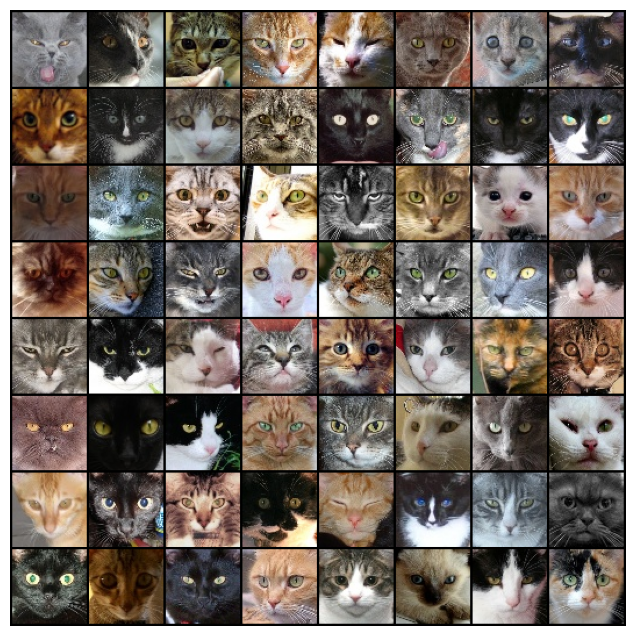

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

for images, _ in train_dl:
    show_images(images, 64)
    break

In [ ]:
generator = nn.Sequential(
    nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake images
    latent = torch.randn(batch_size, 128, 1, 1)
    fake_images = generator(latent)

    # pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # update weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # generate fake images
    latent = torch.randn(batch_size, 128, 1,1)
    fake_images = generator(latent)

    # try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1)
    # comparing
    loss = F.binary_cross_entropy(preds, targets)

    # update generator weights
    loss.backward()
    opt_g.step()

    return loss.item(),latent

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    name = f'generated-images-{index}.png'
    save_image(denormalize(fake_images), os.path.join(path, name), nrow=8)
    print('Saving', name)

fixed_latent = torch.randn(64, 128, 1, 1)
path = 'generated'
os.makedirs(path, exist_ok=True)

In [ ]:
def fit(epochs, lr, start_idx=1):
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # train discriminator
            real_images= real_images
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            # train generator
            loss_g, latent = train_generator(opt_g)

        # record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {}, loss_d: {}, real_score: {}, fake_score: {}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch, fixed_latent)

    return losses_g, losses_d, latent, fake_scores

In [ ]:
model = fit(epochs=15, lr=0.0002)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 3.782679557800293, loss_d: 0.5475364923477173, real_score: 0.7467377781867981, fake_score: 0.1643594205379486
Saving generated-images-0.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 8.003976821899414, loss_d: 0.9699761867523193, real_score: 0.9433374404907227, fake_score: 0.54737788438797
Saving generated-images-1.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 4.609561920166016, loss_d: 0.493099182844162, real_score: 0.7301644086837769, fake_score: 0.0589103177189827
Saving generated-images-2.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 6.517477989196777, loss_d: 0.7431575655937195, real_score: 0.8859710693359375, fake_score: 0.40362051129341125
Saving generated-images-3.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 4.875030994415283, loss_d: 0.5963588953018188, real_score: 0.8276300430297852, fake_score: 0.26551729440689087
Saving generated-images-4.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 3.871687650680542, loss_d: 0.975962221622467, real_score: 0.48692163825035095, fake_score: 0.023531176149845123
Saving generated-images-5.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 6.402034759521484, loss_d: 0.6690397262573242, real_score: 0.8711358308792114, fake_score: 0.3644571304321289
Saving generated-images-6.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 2.35442852973938, loss_d: 1.7735346555709839, real_score: 0.2923094630241394, fake_score: 0.022616228088736534
Saving generated-images-7.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 4.753821849822998, loss_d: 0.5979660749435425, real_score: 0.8234537243843079, fake_score: 0.2673739194869995
Saving generated-images-8.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 3.293896436691284, loss_d: 0.4102288484573364, real_score: 0.8273626565933228, fake_score: 0.15405814349651337
Saving generated-images-9.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 3.506718397140503, loss_d: 0.4990510940551758, real_score: 0.7117981910705566, fake_score: 0.08127282559871674
Saving generated-images-10.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 2.8392605781555176, loss_d: 0.7624759674072266, real_score: 0.6249983906745911, fake_score: 0.15074029564857483
Saving generated-images-11.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 3.661421298980713, loss_d: 0.9835817217826843, real_score: 0.48087525367736816, fake_score: 0.03505101054906845
Saving generated-images-12.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 4.919084548950195, loss_d: 0.4338076412677765, real_score: 0.8123047947883606, fake_score: 0.14783607423305511
Saving generated-images-13.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 3.6779420375823975, loss_d: 0.5135211944580078, real_score: 0.7266221642494202, fake_score: 0.10464654117822647
Saving generated-images-14.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = model

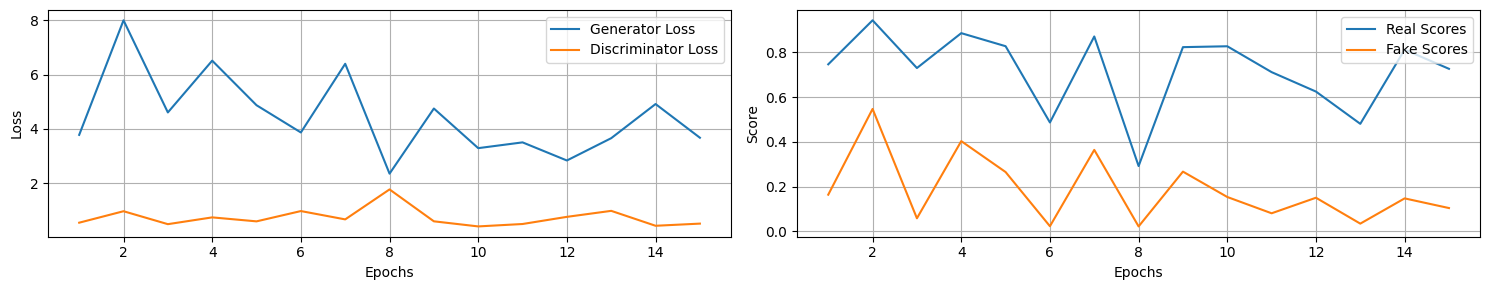

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 16)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

ax1.plot(epochs, losses_g, label="Generator Loss")
ax1.plot(epochs, losses_d, label="Discriminator Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(loc='upper right')
ax1.grid(True)


ax2.plot(epochs, real_scores, label="Real Scores")
ax2.plot(epochs, fake_scores, label="Fake Scores")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Score")
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()

plt.show()


In [ ]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("cats.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)

make_gif('generated2')

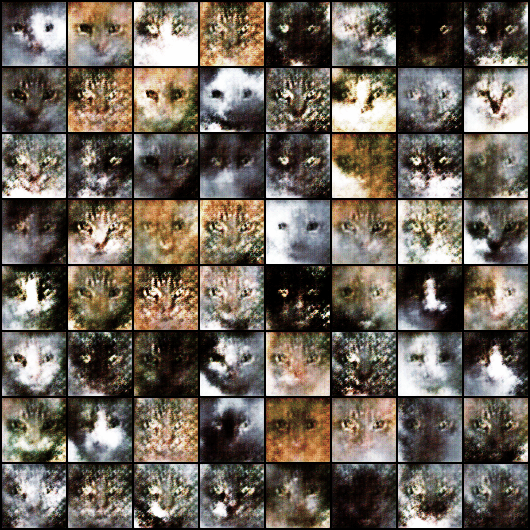

In [ ]:
img(open('cats.gif','rb').read())